In [11]:
!pip install lime

     |████████████████████████████████| 275 kB 21.4 MB/s eta 0:00:01
     |████████████████████████████████| 29.2 MB 39.8 MB/s eta 0:00:01    |█████████▋                      | 8.8 MB 39.8 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 19.2 MB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 46.7 MB/s eta 0:00:01
     |████████████████████████████████| 6.1 MB 63.5 MB/s eta 0:00:01
     |████████████████████████████████| 178 kB 75.0 MB/s eta 0:00:01
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=520f1bca337e804fd1fe4d9b8e1e0173ce29312e6fee7f489ca25e4a2368f060
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime
  Attempting uninstall: pillow
    Found existing installation: Pillow 8.2.0
    Uninstalling Pillow-8.2.0:
      Successfully uninstalled Pillow-8.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages

In [4]:
from catenets.models import TNet, SNet,DRNet
#from importlib import reload  
from catenets.models.representation_nets import SNet1, SNet2

from catenets.experiments.simulation_utils import simulate_treatment_setup
%load_ext autotime
import pandas as pd
import numpy as np
import pickle
import scipy
from scipy.sparse import csr_matrix
import sklearn
from matplotlib import pyplot as plt

time: 423 ms (started: 2021-11-29 17:41:17 +00:00)


In [2]:
data_path = "../antiasthma-v2/"
(Y_tr, T_tr, X_tr, W_tr)=pickle.load(open(data_path+'YTXW_train.pkl','rb'))
(Y_va, T_va, X_va, W_va)=pickle.load(open(data_path+'YTXW_val.pkl','rb'))
(Y_te, T_te, X_te, W_te)=pickle.load(open(data_path+'YTXW_test.pkl','rb'))
#print(Y_tr.shape,Y_va.shape,Y_te.shape)

tot_t = Y_tr.shape[0]
totexs = Y_tr.shape[0]+Y_va.shape[0]+Y_te.shape[0]
tot_tv = Y_tr.shape[0]+Y_va.shape[0]
print(totexs,tot_tv)

11285 9028
time: 112 ms (started: 2021-11-29 16:19:34 +00:00)


In [3]:
W_tr

,patid,phecode3,count,log_count
52,1,7,10,2.397895
53,1,8,1,0.693147
54,1,10,1,0.693147
55,1,11,3,1.386294
56,1,14,2,1.098612
...,...,...,...,...
590421,11282,220,2,1.098612
590422,11282,225,2,1.098612
590423,11282,234,2,1.098612
590424,11282,235,1,0.693147


time: 20 ms (started: 2021-11-29 16:19:35 +00:00)


In [4]:

Y_frames = [Y_tr, Y_va, Y_te]
X_frames = [X_tr, X_va, X_te]
T_frames = [T_tr, T_va, T_te]
W_frames = [W_tr, W_va, W_te]


Y = pd.concat(Y_frames)
Y = np.array(Y)

X = pd.concat(X_frames)
T = pd.concat(T_frames)
W = pd.concat(W_frames)

patids = W.patid.unique()

T = T["antiasthma"]
T.shape,Y.shape,X.shape,W.shape
n_pats = len(W.patid.unique())
n_phecodes = len(W.phecode3.unique())
W_mat = np.zeros((n_pats,n_phecodes))

for row in W.iterrows():
    pid = np.where(patids==int(row[1]["patid"]))
    pcd = int(row[1]["phecode3"])
    W_mat[pid,pcd] = row[1]["log_count"]
    
    
le_dx=pickle.load(open(data_path+'le_dx.pkl','rb'))
a = np.array(T)
Treatment = np.zeros((len(a),6))
ctr = 0
for item in a:
    Treatment[ctr][item] = 1
    ctr = ctr+1
Xs = np.concatenate((W_mat,X),axis=1)
#X = Xs/np.max(Xs,axis=0)

P = np.zeros(totexs)

for i in range(totexs):
    P[i] = 0.5

time: 43.7 s (started: 2021-11-29 16:19:35 +00:00)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


# Estimate CATE using TNet

In [ ]:


ermse = 0.0
cate_pred_all = []
ctr = 0
for k in range(5,6):
    print("For treatment: ",k)
    t = TNet(val_split_prop=0.25,n_iter=1500,batch_size=500)
    w = np.array(Treatment[0:tot_tv,k],dtype=int)
    y = np.array(Y[0:tot_tv],dtype=int)
    X_train = Xs[0:tot_tv]
    #print(X_train)
    X_test = Xs[tot_tv :totexs]
    #cate = cate[0:tot_tv]
    p = P[0:tot_tv]
    t.fit(X_train, y, w) # w is t here 
    cate_pred_train = t.predict(X_test) # without potential outcomes
    t_test = TNet()
    t_test.fit(X_test, Y[tot_tv :totexs], np.array(Treatment[tot_tv :totexs,k],dtype=int)) # w is t here 
    cate_pred_test = t_test.predict(X_test) 
    cate_pred_all.append(cate_pred_train)
    ermse = ermse+(np.square(cate_pred_train - cate_pred_test).mean())
    ctr = ctr+1
    


ermse = ermse/ctr


In [33]:
print("The estimated root mean squared error for the TNet is: ",ermse)

The estimated root mean squared error for the TNet is:  0.08795806765556335
time: 1.31 ms (started: 2021-08-12 19:14:14 +00:00)


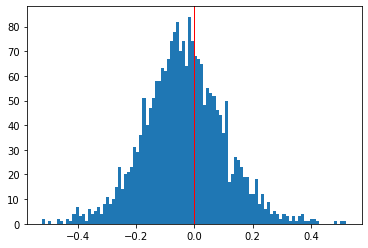

time: 452 ms (started: 2021-08-12 19:14:50 +00:00)


In [35]:
for k in range(5,6):
    plt.clf()
    n, bins, patches = plt.hist(np.array(cate_pred_all[0]),bins=100) #0 to k-1 for range 1 to 6
    plt.axvline(linewidth=1, color='r')
    plt.show()

# Estimate CATE using SNet1 = CFRNet

In [19]:
# estimate CATE using SNet1 =CFRNet

ermse = 0.0
cate_pred_all = []
ctr = 0
for k in range(5,6):
    print("\n For treatment: ",k)
    
    t = SNet1(val_split_prop=0.25,n_iter=1500,batch_size=100)
    w = np.array(Treatment[0:tot_tv,k],dtype=int)
    y = np.array(Y[0:tot_tv],dtype=int)
    X_train = Xs[0:tot_tv]
    #print(X_train)
    X_test = Xs[tot_tv :totexs]
    #cate = cate[0:tot_tv]
    p = P[0:tot_tv]
    t.fit(X_train, y, w) # w is t here 
    cate_pred_train = t.predict(X_test) # without potential outcomes
    t_test = SNet1(val_split_prop=0.1,n_iter=1500,batch_size=100)
    print("Now fitting on test data for ERMSE")
    t_test.fit(X_test, Y[tot_tv :totexs], np.array(Treatment[tot_tv :totexs,k],dtype=int)) # w is t here 
    cate_pred_test = t_test.predict(X_test) 
    cate_pred_all.append(cate_pred_train)
    ermse = ermse+(np.square(cate_pred_train - cate_pred_test).mean())
    ctr = ctr+1
    

    
ermse = ermse/ctr





 For treatment:  5
Epoch: 0, current validation loss 0.18955309689044952
Now fitting on test data for ERMSE
Epoch: 0, current validation loss 0.18453781306743622
time: 26.4 s (started: 2021-09-10 17:59:24 +00:00)


In [20]:
print("The estimated root mean squared error for the CFRNet is: ",ermse)

The estimated root mean squared error for the CFRNet is:  0.05476769432425499
time: 1.31 ms (started: 2021-09-10 17:59:51 +00:00)


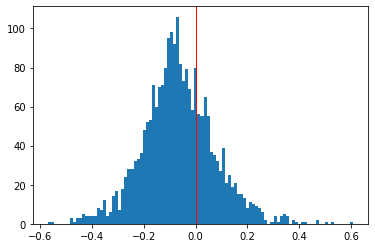

time: 350 ms (started: 2021-09-10 18:00:20 +00:00)


In [22]:
for k in range(5,6):
    plt.clf()
    n, bins, patches = plt.hist(np.array(cate_pred_train),bins=100) #0 to k-1 for range 1 to 6
    plt.axvline(linewidth=1, color='r')
    plt.show()

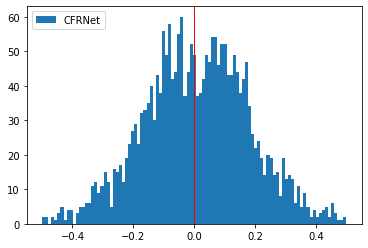

time: 394 ms (started: 2021-08-13 21:10:43 +00:00)


In [239]:
bins = np.linspace(-0.5, 0.5, 100)
data1 = [cate_pred_test.flatten()]
plt.hist(data1, bins, label = ['CFRNet'])
plt.axvline(linewidth=1, color='r')
plt.legend(loc='upper left')

# estimate CATE using SNet = S Learner

In [154]:


ermse = 0.0
cate_pred_all = []
ctr = 0 
for k in range(5,6):
    print("\n For treatment: ",k)
    
    t = SNet(val_split_prop=0.25,n_iter=1500,batch_size=500)
    w = np.array(Treatment[0:tot_tv,k],dtype=int)
    y = np.array(Y[0:tot_tv],dtype=int)
    X_train = X[0:tot_tv]
    #print(X_train)
    X_test = X[tot_tv :totexs]
    #cate = cate[0:tot_tv]
    p = P[0:tot_tv]
    t.fit(X_train, y, w) # w is t here 
    cate_pred_train = t.predict(X_test) # without potential outcomes
    t_test = SNet(val_split_prop=0.1,n_iter=1500,batch_size=500)
    print("Now fitting on test data for ERMSE")
    t_test.fit(X_test, Y[tot_tv :totexs], np.array(Treatment[tot_tv :totexs,k],dtype=int)) # w is t here 
    cate_pred_test = t_test.predict(X_test) 
    cate_pred_all.append(cate_pred_train)
    ermse = ermse+(np.square(cate_pred_train - cate_pred_test).mean())
    ctr = ctr+1
    

    
ermse = ermse/ctr





 For treatment:  5
Epoch: 0, current validation loss 473.84136962890625
Epoch: 50, current validation loss 62.80744171142578
Epoch: 100, current validation loss 11.953031539916992
Epoch: 150, current validation loss 3.2879958152770996
Epoch: 200, current validation loss 1.4003797769546509
Epoch: 250, current validation loss 0.9190294742584229
Epoch: 300, current validation loss 0.7818131446838379
Epoch: 350, current validation loss 0.7391136288642883
Epoch: 400, current validation loss 0.7237522602081299
Now fitting on test data for ERMSE
Epoch: 0, current validation loss 488.7472839355469
Epoch: 50, current validation loss 264.3348693847656
Epoch: 100, current validation loss 146.90472412109375
Epoch: 150, current validation loss 84.13914489746094
Epoch: 200, current validation loss 49.5791015625
Epoch: 250, current validation loss 30.084522247314453
Epoch: 300, current validation loss 18.793746948242188
Epoch: 350, current validation loss 12.084972381591797
Epoch: 400, current valid

In [155]:
print("The estimated root mean squared error for the SNet is: ",ermse)

The estimated root mean squared error for the SNet is:  0.03364619240164757
time: 985 µs (started: 2021-08-12 20:45:44 +00:00)


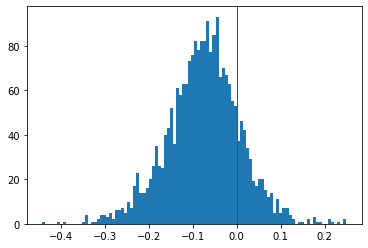

time: 334 ms (started: 2021-08-12 20:45:44 +00:00)


In [156]:
for k in range(5,6):
    plt.clf()
    n, bins, patches = plt.hist(np.array(cate_pred_all[0]),bins=100) #0 to k-1 for range 1 to 6
    plt.axvline(linewidth=1, color='r')
    plt.show()

# estimate CATE using SNet2 = DragonNet

In [5]:


ermse = 0.0
cate_pred_all = []
ctr = 0
for k in range(5,6):
    print("\n For treatment: ",k)
    
    t = SNet2(val_split_prop=0.25,n_iter=1500,batch_size=500)
    w = np.array(Treatment[0:tot_tv,k],dtype=int)
    y = np.array(Y[0:tot_tv],dtype=int)
    X_train = Xs[0:tot_tv]
    #print(X_train)
    X_test = Xs[tot_tv :totexs]
    #cate = cate[0:tot_tv]
    p = P[0:tot_tv]
    t.fit(X_train, y, w) # w is t here 
    cate_pred_train = t.predict(X_test) # without potential outcomes
    t_test = SNet2(val_split_prop=0.1,n_iter=1500,batch_size=500)
    print("Now fitting on test data for ERMSE")
    t_test.fit(X_test, Y[tot_tv :totexs], np.array(Treatment[tot_tv :totexs,k],dtype=int)) # w is t here 
    cate_pred_test = t_test.predict(X_test) 
    cate_pred_all.append(cate_pred_train)
    ermse = ermse+(np.square(cate_pred_train - cate_pred_test).mean())
    ctr = ctr+1
    

    
ermse = ermse/ctr





 For treatment:  5
Epoch: 0, current validation loss 0.8309612274169922
Now fitting on test data for ERMSE
Epoch: 0, current validation loss 0.8949765563011169
Epoch: 50, current validation loss 0.611284613609314
Epoch: 100, current validation loss 0.5898926258087158
time: 38.2 s (started: 2021-11-29 16:20:18 +00:00)


In [6]:
print("The estimated root mean squared error for the DragonNet is: ",ermse)

The estimated root mean squared error for the DragonNet is:  0.04019579291343689
time: 1.46 ms (started: 2021-11-29 16:20:57 +00:00)


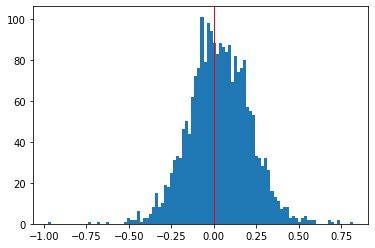

time: 374 ms (started: 2021-11-29 16:20:57 +00:00)


In [7]:
for k in range(5,6):
    plt.clf()
    n, bins, patches = plt.hist(np.array(cate_pred_test),bins=100) #0 to k-1 for range 1 to 6
    plt.axvline(linewidth=1, color='r')
    plt.show()

# DR Net

In [393]:
ermse = 0.0
cate_pred_all = []
ctr = 0
for k in range(5,6):
    print("\n For treatment: ",k)
    
    t = DRNet(val_split_prop=0.25,n_iter=1500,batch_size=100)
    w = np.array(Treatment[0:tot_tv,k],dtype=int)
    y = np.array(Y[0:tot_tv],dtype=int)
    X_train = Xs[0:tot_tv]
    #print(X_train)
    X_test = Xs[tot_tv :totexs]
    #cate = cate[0:tot_tv]
    p = P[0:tot_tv]
    t.fit(X_train, y, w) # w is t here 
    cate_pred_train = t.predict(X_test) # without potential outcomes
    t_test = SNet1(val_split_prop=0.1,n_iter=1500,batch_size=100)
    print("Now fitting on test data for ERMSE")
    t_test.fit(X_test, Y[tot_tv :totexs], np.array(Treatment[tot_tv :totexs,k],dtype=int)) # w is t here 
    cate_pred_test = t_test.predict(X_test) 
    cate_pred_all.append(cate_pred_train)
    ermse = ermse+(np.square(cate_pred_train - cate_pred_test).mean())
    ctr = ctr+1
    

    
ermse = ermse/ctr



 For treatment:  5
Training first stage with all data (no data splitting)
Training PO_0 Net
Epoch: 0, current validation loss: 0.1632564812898636
Training PO_1 Net
Epoch: 0, current validation loss: 0.47067999839782715
Training propensity net
Epoch: 0, current validation loss: 0.5933991074562073
Training second stage.
Epoch: 0, current validation loss: 1.0979541540145874
Now fitting on test data for ERMSE
Epoch: 0, current validation loss 0.18453781306743622
time: 57.1 s (started: 2021-08-27 19:00:53 +00:00)


In [9]:
print("The estimated root mean squared error for the DRNet is: ",ermse)

The estimated root mean squared error for the DRNet is:  0.04019579291343689
time: 1.68 ms (started: 2021-11-29 16:22:26 +00:00)


**Check the IF-PEHE for test set for a given model**

In [10]:
from sklearn import preprocessing

def prepare(y, tr, w, x, rx2id, target):
    patid_temp = list(w['patid'].unique())
    temp_le = preprocessing.LabelEncoder()
    temp_le.fit(list(patid_temp))
    w['row_idx'] = temp_le.transform(w['patid'])
    
    w_sparse = csr_matrix((w['log_count'], (w['row_idx'], w['phecode3'])))
    w = w_sparse.toarray()
    
    x_temp = np.concatenate((w, x.values), axis=1)
    
    treatment_train = [0] * len(tr)
    temp_index = tr.index
    idx = 0

    def get_classes(value):
        return [k for k, v in rx2id.items() if v == value]

    for i in temp_index:
        classes = tr.loc[i, 'antiasthma']
        if (classes != target):
            treatment_train[idx] = 'control'
        else:
            treatment_train[idx] = 'treatment'
        idx += 1
        
    treatment = pd.DataFrame(treatment_train)
    treatment.index = temp_index
    treatment.columns = ['treatment']
    
    y = pd.DataFrame(y)
    feature_df = pd.DataFrame(x_temp)
    feature_df.index = y.index
    
    df = pd.concat([y, treatment, tr, feature_df], axis=1)
    df.index = np.arange(0, len(df))
    return df

le_dx=pickle.load(open(data_path+'le_dx.pkl','rb'))
le_patid=pickle.load(open(data_path+'le_patid.pkl','rb'))
selected_patient_feature=['age_onset','obs_win','female']+['race__'+c for c in ['A','B','H','U','W']]
rx2id = pickle.load(open(data_path+'drug_dict.pkl', 'rb'))

target = 5
df_val0 = prepare(Y_va, T_va, W_va, X_va, rx2id, target)
df_test0 = prepare(Y_te, T_te, W_te, X_te, rx2id, target)
df_train0 = prepare(Y_tr, T_tr, W_tr, X_tr, rx2id, target)

x_train0 = df_train0.iloc[:, 5:]
x_test0 = df_test0.iloc[:, 5:]
x_val0 = df_val0.iloc[:, 5:]

y_val = df_val0['adrd']



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


time: 256 ms (started: 2021-11-29 16:22:31 +00:00)


In [11]:
x_train0

,0,1,2,3,4,5,6,7,8,9,...,239,240,241,242,243,244,245,246,247,248
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,2.397895,0.693147,0.000000,...,0.0,0.000000,0.0,75.0,1.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,1.098612,1.098612,0.693147,0.693147,0.0,2.639057,1.386294,0.000000,...,0.0,0.000000,0.0,72.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.000000,0.000000,0.000000,0.000000,2.197225,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,74.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.000000,0.000000,0.000000,0.000000,1.791759,0.0,0.000000,1.098612,0.693147,...,0.0,0.000000,0.0,83.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,84.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6766,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,90.0,0.0,0.0,0.0,0.0,0.0,1.0
6767,0.0,0.000000,0.693147,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,83.0,1.0,0.0,0.0,0.0,0.0,1.0
6768,0.0,0.000000,0.693147,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,88.0,0.0,0.0,0.0,1.0,0.0,0.0
6769,0.0,0.000000,0.693147,0.000000,0.000000,1.386294,0.0,0.000000,0.000000,0.000000,...,0.0,0.693147,0.0,89.0,0.0,0.0,0.0,0.0,0.0,1.0


time: 30.5 ms (started: 2021-11-29 16:22:31 +00:00)


In [12]:
from xgboost import XGBClassifier, XGBRegressor
xgb = XGBClassifier(max_depth=6, random_state=1105, n_estimators=100)
xgb_plugin1 = XGBClassifier(max_depth=6, random_state=1105, n_estimators=100)
xgb_plugin0 = XGBClassifier(max_depth=6, random_state=1108, n_estimators=100)

x0 = df_train0.loc[df_train0['treatment'] == 'control', 0:248]
y0 = df_train0.loc[df_train0['treatment'] == 'control', 'adrd']
xgb_plugin0.fit(x0, y0)


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:22:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=336, num_parallel_tree=1,
              random_state=1108, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

time: 11min 1s (started: 2021-11-29 16:22:32 +00:00)


In [13]:
x1 = df_train0.loc[df_train0['treatment'] == 'treatment', 0:248]
y1 = df_train0.loc[df_train0['treatment'] == 'treatment', 'adrd']
xgb_plugin1.fit(x1, y1)



[16:33:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=336, num_parallel_tree=1,
              random_state=1105, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

time: 6min 59s (started: 2021-11-29 16:33:33 +00:00)


In [14]:
y_pred0 = xgb_plugin0.predict(x_test0)
y_pred1 = xgb_plugin1.predict(x_test0)
t_plugin = y_pred1 - y_pred0


time: 660 ms (started: 2021-11-29 16:40:32 +00:00)


In [15]:
t = df_train0['treatment']

treatment = [0] * len(t)
for i in range(len(t)):
    if t[i] == 'control':
        treatment[i] = 0
    else:
        treatment[i] = 1

xgb.fit(x_train0,treatment)

[16:40:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=336, num_parallel_tree=1,
              random_state=1105, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

time: 13min 36s (started: 2021-11-29 16:40:33 +00:00)


In [16]:
cate = cate_pred_train.flatten()



t_test = df_test0['treatment']
#print(t_test)
treatment_test = [0] * len(t_test)
for i in range(len(t_test)):
    if t_test[i] == 'control':
        treatment_test[i] = 0
    else:
        treatment_test[i] = 1 
        
y_test = df_test0['adrd']

t_val = df_val0['treatment']
treatment_val = [0] * len(t_val)
for i in range(len(t_val)):
    if t_val[i] == 'control':
        treatment_val[i] = 0
    else:
        treatment_val[i] = 1 
        




time: 29.7 ms (started: 2021-11-29 16:54:09 +00:00)


In [17]:
plug_in = (t_plugin-cate)**2
ps = xgb.predict_proba(x_test0)[:, 1]
a = (treatment_test - ps)
ident = np.array([1]*len(ps))
ps

c = (ps*(ident-ps))
c

b = np.array([2]*len(treatment_test))*treatment_test*(treatment_test-ps) / c

b


array([-0.        , -0.        , -0.        , ...,  4.55257702,
       -0.        , -0.        ])

time: 361 ms (started: 2021-11-29 16:54:09 +00:00)


In [18]:
y_pred1.sum()

10

time: 2.15 ms (started: 2021-11-29 16:54:10 +00:00)


In [19]:
l_de = (ident - b) * t_plugin**2 + b*y_val*(t_plugin - cate) + (- a*(t_plugin - cate)**2 + cate**2)


print(np.sum(l_de) + np.sum(plug_in))

53.573654
time: 428 ms (started: 2021-11-29 16:54:10 +00:00)
